## Получение входов для функции получения SPI, SPEI

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import math
import numpy as np
from datetime import datetime, timedelta

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
X = np.load("/content/drive/MyDrive/cmc/nauchka/data/prepared/Y_hourly.npy")
np.any(np.isinf(X))

np.False_

### утилиты для обработки nan/inf в данных

In [ ]:
def sanitize_np(a: np.ndarray) -> np.ndarray:
    return np.nan_to_num(a, nan=0.0, posinf=0.0, neginf=0.0)

def sanitize_torch(t: torch.Tensor) -> torch.Tensor:
    return torch.nan_to_num(t, nan=0.0, posinf=0.0, neginf=0.0)

In [ ]:
BASE_DIR = "/content/drive/MyDrive/cmc/nauchka/data"

TP_HOURLY_CANDIDATES = ["tp_hourly.npy", "tp_hourly_362d.npy", "tp.npy"]

VARS6H = {
    "t2m": ["t2m_6h.npy", "t2m.npy"],
    "d2m": ["d2m_6h.npy", "d2m.npy"],
    "msl": ["msl_6h.npy", "msl.npy"],
    "u10": ["u10_6h.npy", "u10.npy"],
    "v10": ["v10_6h.npy", "v10.npy"],
}

START_DATE_UTC = "2025-01-01"
N_DAYS_LIMIT = 362
PAST_DAYS = 7
HORIZON_DAYS = 7
THRESHOLD_MM = 20.0

BATCH_SIZE = 2
NUM_WORKERS = 0
EPOCHS = 5
LR = 1e-4
BASE_CHANNELS = 32

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


### utils...

In [ ]:
def resolve_path(base_dir, candidates):
    for name in candidates:
        p = os.path.join(base_dir, name)
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"None of these files found in {base_dir}: {candidates}")

def require_3d(name, arr):
    if arr.ndim != 3:
        raise ValueError(
            f"{name} must be 3D (time, lat, lon). Got shape {arr.shape}.\n"
            f"If this is tp and you have shape like (hours_in_month, 12, H, W), "
            f"you need to re-export tp from GRIB to a continuous hourly timeline (T_hours,H,W)."
        )

### dataset

In [ ]:
class Era5WeeklyRiskDataset(Dataset):
    def __init__(
        self,
        tp_hourly_path: str,
        vars6h_paths: dict,
        start_date_utc: str,
        past_days: int = 7,
        horizon_days: int = 7,
        threshold_mm: float = 20.0,
        max_days: int | None = None,
        day_indices=None,
        norm_mean: torch.Tensor | None = None,
        norm_std: torch.Tensor | None = None,
    ):
        super().__init__()

        self.tp = np.load(tp_hourly_path, mmap_mode="r")
        require_3d("tp_hourly", self.tp)

        self.vars6h = {}
        for k, p in vars6h_paths.items():
            arr = np.load(p, mmap_mode="r")
            require_3d(k, arr)
            self.vars6h[k] = arr

        Th, H, W = self.tp.shape
        any6 = next(iter(self.vars6h.values()))
        T6, H2, W2 = any6.shape
        assert (H, W) == (H2, W2), "Spatial mismatch between tp and 6h variables"

        assert Th % 24 == 0, f"tp hours must be divisible by 24, got {Th}"
        assert T6 % 4 == 0, f"6h timesteps must be divisible by 4, got {T6}"

        D_tp = Th // 24
        D_6h = T6 // 4
        D_common = min(D_tp, D_6h)
        if max_days is not None:
            D_common = min(D_common, int(max_days))

        self.H, self.W = H, W
        self.D = D_common
        self.past_days = int(past_days)
        self.horizon_days = int(horizon_days)
        self.threshold_mm = float(threshold_mm)

        self.start_date = datetime.strptime(start_date_utc, "%Y-%m-%d")

        d_min = self.past_days - 1
        d_max = self.D - self.horizon_days - 1
        assert d_max >= d_min, f"Not enough days. D={self.D}, need past={self.past_days}, horizon={self.horizon_days}"

        if day_indices is None:
            self.day_indices = np.arange(d_min, d_max + 1, dtype=np.int32)
        else:
            di = np.asarray(day_indices, dtype=np.int32)
            ok = (di >= d_min) & (di <= d_max)
            self.day_indices = di[ok]

        self.var_order = ["msl", "u10", "v10", "t2m", "d2m"]
        for v in self.var_order:
            if v not in self.vars6h:
                raise KeyError(f"Missing 6h variable {v}")

        self.num_channels = 26

        self.norm_mean = norm_mean
        self.norm_std = norm_std

    def __len__(self):
        return len(self.day_indices)

    def _tp24_block_mm(self, day_start: int, day_end_exclusive: int) -> np.ndarray:
        assert 0 <= day_start < day_end_exclusive <= self.D
        h0 = day_start * 24
        h1 = day_end_exclusive * 24
        block = self.tp[h0:h1].astype(np.float32) * 1000.0
        num_days = day_end_exclusive - day_start
        return block.reshape(num_days, 24, self.H, self.W).sum(axis=1, dtype=np.float32)

    def _seasonal_maps(self, day: int):
        date = self.start_date + timedelta(days=int(day))
        doy = date.timetuple().tm_yday
        angle = 2.0 * math.pi * (doy / 365.0)
        s = math.sin(angle)
        c = math.cos(angle)
        sin_map = np.full((self.H, self.W), s, dtype=np.float32)
        cos_map = np.full((self.H, self.W), c, dtype=np.float32)
        return sin_map, cos_map

    def __getitem__(self, idx: int):
        d = int(self.day_indices[idx])

        X_channels = []

        t6_start = (d - (self.past_days - 1)) * 4
        t6_end = (d + 1) * 4
        n_last2 = 2 * 4

        for v in self.var_order:
            arr = self.vars6h[v][t6_start:t6_end].astype(np.float32)

            mean_7d = arr.mean(axis=0, dtype=np.float32)
            min_7d = arr.min(axis=0)
            max_7d = arr.max(axis=0)

            last2 = arr[-n_last2:]
            prev5 = arr[:-n_last2]
            trend = last2.mean(axis=0, dtype=np.float32) - prev5.mean(axis=0, dtype=np.float32)

            X_channels.extend([mean_7d, min_7d, max_7d, trend])

        tp24_past = self._tp24_block_mm(d - 6, d + 1)
        tp24_today = tp24_past[-1]
        tp24_yday = tp24_past[-2]
        tp24_sum_7d = tp24_past.sum(axis=0, dtype=np.float32)
        tp24_max_7d = tp24_past.max(axis=0)
        X_channels.extend([tp24_today, tp24_yday, tp24_sum_7d, tp24_max_7d])

        sin_map, cos_map = self._seasonal_maps(d)
        X_channels.extend([sin_map, cos_map])

        X = np.stack(X_channels, axis=0).astype(np.float32)

        tp24_future = self._tp24_block_mm(d + 1, d + 1 + self.horizon_days)
        future_max = tp24_future.max(axis=0)
        y = (future_max > self.threshold_mm).astype(np.float32)[None, :, :]

        X_t = torch.from_numpy(X)
        y_t = torch.from_numpy(y)

        if self.norm_mean is not None and self.norm_std is not None:
            X_t = (X_t - self.norm_mean[:, None, None]) / self.norm_std[:, None, None]

        X_t = sanitize_np(X_t)
        y_t = sanitize_np(y_t)
        return X_t, y_t

### ResUnet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, padding=1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1)
        self.skip = nn.Conv2d(in_c, out_c, 1) if in_c != out_c else nn.Identity()
        self.bn1 = nn.BatchNorm2d(out_c)
        self.bn2 = nn.BatchNorm2d(out_c)

    def forward(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        return F.relu(h + self.skip(x))

def center_crop(x, target_h, target_w):
    _, _, h, w = x.shape
    if h == target_h and w == target_w:
        return x
    top = max((h - target_h) // 2, 0)
    left = max((w - target_w) // 2, 0)
    return x[:, :, top:top+target_h, left:left+target_w]

class ResUNet(nn.Module):
    def __init__(self, in_channels=26, out_channels=1, base=32):
        super().__init__()
        self.enc1 = ResBlock(in_channels, base)
        self.enc2 = ResBlock(base, base*2)
        self.enc3 = ResBlock(base*2, base*4)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = ResBlock(base*4, base*8)

        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec3 = ResBlock(base*8, base*4)

        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = ResBlock(base*4, base*2)

        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = ResBlock(base*2, base)

        self.out = nn.Conv2d(base, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.up3(b)
        e3c = center_crop(e3, d3.shape[-2], d3.shape[-1])
        d3 = self.dec3(torch.cat([d3, e3c], dim=1))

        d2 = self.up2(d3)
        e2c = center_crop(e2, d2.shape[-2], d2.shape[-1])
        d2 = self.dec2(torch.cat([d2, e2c], dim=1))

        d1 = self.up1(d2)
        e1c = center_crop(e1, d1.shape[-2], d1.shape[-1])
        d1 = self.dec1(torch.cat([d1, e1c], dim=1))

        out = self.out(d1)
        if out.shape[-2:] != x.shape[-2:]:
            out = F.interpolate(out, size=x.shape[-2:], mode="bilinear", align_corners=False)
        return out

### утилиты для подсчета скора

In [ ]:
@torch.no_grad()
def brier_score(model, loader):
    model.eval()
    total = 0.0
    n = 0
    for X, y in loader:
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        p = torch.sigmoid(model(X))
        total += ((p - y) ** 2).sum().item()
        n += y.numel()
    return total / max(n, 1)

@torch.no_grad()
def ece_score(model, loader, n_bins=10, max_batches=20):
    model.eval()
    bins = torch.linspace(0, 1, n_bins + 1, device=device)
    ece = 0.0
    seen = 0

    for b, (X, y) in enumerate(loader):
        if b >= max_batches:
            break
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        p = torch.sigmoid(model(X)).flatten()
        y = y.flatten()

        batch_ece = 0.0
        for i in range(n_bins):
            mask = (p >= bins[i]) & (p < bins[i+1])
            if mask.any():
                acc = y[mask].float().mean()
                conf = p[mask].mean()
                frac = mask.float().mean()
                batch_ece += (frac * torch.abs(acc - conf)).item()

        ece += batch_ece
        seen += 1

    return ece / max(seen, 1)

### utils...

In [ ]:
def compute_norm_stats(loader, num_channels=26):
    sum_ = torch.zeros(num_channels, dtype=torch.float64)
    sumsq = torch.zeros(num_channels, dtype=torch.float64)
    n = 0

    for X, _ in tqdm(loader, desc="Compute mean/std (stable)"):
        X = X.to(torch.float64)
        B, C, H, W = X.shape

        sum_ += X.sum(dim=(0, 2, 3))
        sumsq += (X * X).sum(dim=(0, 2, 3))
        n += B * H * W

    mean = sum_ / n
    var = sumsq / n - mean * mean

    var = torch.clamp(var, min=1e-12)
    std = torch.sqrt(var)

    return mean.to(torch.float32), std.to(torch.float32)

@torch.no_grad()
def compute_pos_weight(loader):
    pos = 0
    neg = 0
    for _, y in tqdm(loader, desc="Compute pos_weight"):
        pos += (y == 1).sum().item()
        neg += (y == 0).sum().item()
    w = neg / max(pos, 1)
    return torch.tensor([w], dtype=torch.float32)

### train_loop

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total = 0.0
    for X, y in tqdm(loader, desc="Train", leave=False):
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total += loss.item()
    return total / len(loader)

@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    total = 0.0
    for X, y in tqdm(loader, desc="Val", leave=False):
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(X)
        loss = criterion(logits, y)
        total += loss.item()
    return total / len(loader)

### вывод train_loop

In [ ]:
tp_path = resolve_path(BASE_DIR, TP_HOURLY_CANDIDATES)

vars6h_paths = {}
for v, cand in VARS6H.items():
    vars6h_paths[v] = resolve_path(BASE_DIR, cand)

print("tp:", tp_path)
print("6h vars:", vars6h_paths)

tp = np.load(tp_path, mmap_mode="r")
require_3d("tp", tp)
any6 = np.load(next(iter(vars6h_paths.values())), mmap_mode="r")
require_3d("any6h", any6)

D_tp = tp.shape[0] // 24
D_6h = any6.shape[0] // 4
D_common = min(D_tp, D_6h, N_DAYS_LIMIT)

print("tp shape:", tp.shape, "days:", D_tp)
print("6h shape:", any6.shape, "days:", D_6h)
print("Using common days:", D_common)

d_min = PAST_DAYS - 1
d_max = D_common - HORIZON_DAYS - 1
all_days = np.arange(d_min, d_max + 1, dtype=np.int32)

split = int(0.8 * len(all_days))
train_days = all_days[:split]
val_days = all_days[split:]

print("Samples total:", len(all_days), "train:", len(train_days), "val:", len(val_days))

tp: /content/drive/MyDrive/cmc/nauchka/data/tp.npy
6h vars: {'t2m': '/content/drive/MyDrive/cmc/nauchka/data/t2m.npy', 'd2m': '/content/drive/MyDrive/cmc/nauchka/data/d2m.npy', 'msl': '/content/drive/MyDrive/cmc/nauchka/data/msl.npy', 'u10': '/content/drive/MyDrive/cmc/nauchka/data/u10.npy', 'v10': '/content/drive/MyDrive/cmc/nauchka/data/v10.npy'}
tp shape: (8688, 125, 205) days: 362
6h shape: (1448, 125, 205) days: 362
Using common days: 362
Samples total: 349 train: 279 val: 70


### достаем данные из dataloader

In [ ]:
train_ds_raw = Era5WeeklyRiskDataset(
    tp_hourly_path=tp_path,
    vars6h_paths=vars6h_paths,
    start_date_utc=START_DATE_UTC,
    past_days=PAST_DAYS,
    horizon_days=HORIZON_DAYS,
    threshold_mm=THRESHOLD_MM,
    max_days=D_common,
    day_indices=train_days,
)

train_loader_raw = DataLoader(
    train_ds_raw, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

mean, std = compute_norm_stats(train_loader_raw, num_channels=train_ds_raw.num_channels)
pos_weight = compute_pos_weight(train_loader_raw)

print("mean/std shapes:", mean.shape, std.shape)
print("pos_weight:", pos_weight.item())

Compute pos_weight: 100%|██████████| 140/140 [00:12<00:00, 11.43it/s]

mean/std shapes: torch.Size([26]) torch.Size([26])
pos_weight: 33.38588333129883


In [ ]:
train_ds = Era5WeeklyRiskDataset(
    tp_hourly_path=tp_path,
    vars6h_paths=vars6h_paths,
    start_date_utc=START_DATE_UTC,
    past_days=PAST_DAYS,
    horizon_days=HORIZON_DAYS,
    threshold_mm=THRESHOLD_MM,
    max_days=D_common,
    day_indices=train_days,
    norm_mean=mean,
    norm_std=std,
)

val_ds = Era5WeeklyRiskDataset(
    tp_hourly_path=tp_path,
    vars6h_paths=vars6h_paths,
    start_date_utc=START_DATE_UTC,
    past_days=PAST_DAYS,
    horizon_days=HORIZON_DAYS,
    threshold_mm=THRESHOLD_MM,
    max_days=D_common,
    day_indices=val_days,
    norm_mean=mean,
    norm_std=std,
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

X0, y0 = next(iter(train_loader))
print("X batch:", X0.shape, "y batch:", y0.shape)

X batch: torch.Size([2, 26, 125, 205]) y batch: torch.Size([2, 1, 125, 205])


### train_loop activate

In [ ]:
model = ResUNet(in_channels=26, out_channels=1, base=BASE_CHANNELS).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

best_val_brier = float("inf")
save_path = os.path.join(BASE_DIR, "resunet_best.pt")

for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss = validate(model, val_loader, criterion)

    va_brier = brier_score(model, val_loader)
    va_ece = ece_score(model, val_loader, n_bins=10, max_batches=20)

    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | "
          f"val_brier={va_brier:.5f} | val_ece≈{va_ece:.5f}")

    if va_brier < best_val_brier:
        best_val_brier = va_brier
        torch.save(
            {
                "model_state": model.state_dict(),
                "norm_mean": mean,
                "norm_std": std,
                "pos_weight": pos_weight,
                "config": {
                    "past_days": PAST_DAYS,
                    "horizon_days": HORIZON_DAYS,
                    "threshold_mm": THRESHOLD_MM,
                    "base_channels": BASE_CHANNELS,
                    "start_date_utc": START_DATE_UTC,
                    "days_used": D_common,
                }
            },
            save_path
        )
        print("Saved best model to:", save_path)

print("Done. Best val_brier:", best_val_brier)

Epoch 01 | train_loss=1.2302 | val_loss=0.7829 | val_brier=0.17411 | val_ece≈0.41959
Saved best model to: /content/drive/MyDrive/cmc/nauchka/data/resunet_best.pt


Epoch 02 | train_loss=1.1066 | val_loss=0.7792 | val_brier=0.20464 | val_ece≈0.47343


Epoch 03 | train_loss=1.0310 | val_loss=0.6725 | val_brier=0.09975 | val_ece≈0.29552
Saved best model to: /content/drive/MyDrive/cmc/nauchka/data/resunet_best.pt


Epoch 04 | train_loss=0.9547 | val_loss=0.6989 | val_brier=0.10001 | val_ece≈0.24388


Epoch 05 | train_loss=0.8445 | val_loss=0.7210 | val_brier=0.04667 | val_ece≈0.12465
Saved best model to: /content/drive/MyDrive/cmc/nauchka/data/resunet_best.pt
Done. Best val_brier: 0.0466706623611716


Что предсказываем
Не “сколько мм осадков”, а карту вероятности события:
“в ближайшие 7 дней в этой ячейке хотя бы в один день выпадет > 20 мм”
То есть это бинарная задача по каждой клетке (1/0), а выход — вероятность (через sigmoid).
Как формируются входы (26 каналов)
Берётся последняя неделя (7 дней) истории и из неё делаются “сжатые” признаки по каждому пикселю:
Для 5 метеопеременных с шагом 6 часов (msl, u10, v10, t2m, d2m):
mean, min, max за 7 дней + trend (среднее последних 2 суток минус среднее первых 5 суток).
Это 5 * 4 = 20 каналов.
Для осадков tp (почасовые → суммируем в суточные мм):
сегодня, вчера, сумма за 7 дней, максимум за 7 дней = 4 канала.
Сезонность: sin(doy) и cos(doy) = 2 канала.

### visualize

Loaded best model from: /content/drive/MyDrive/cmc/nauchka/data/resunet_best.pt
[Val batch metrics @thr=0.5] acc=0.9254 precision=0.1026 recall=0.6392 iou=0.0970


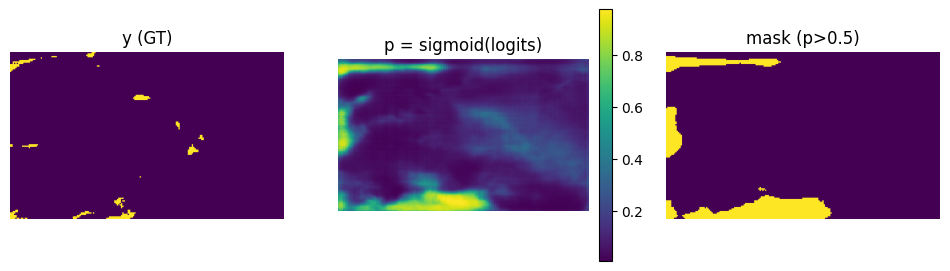

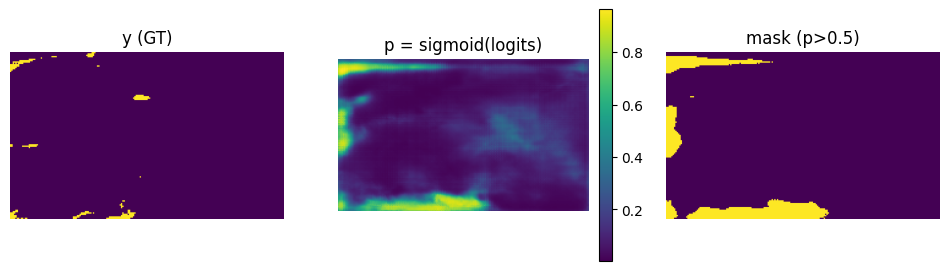

[Val subset @thr=0.3] acc=0.8923 precision=0.0642 recall=0.5123 iou=0.0605
[Val subset @thr=0.5] acc=0.9416 precision=0.0989 recall=0.4091 iou=0.0866
[Val subset @thr=0.7] acc=0.9671 precision=0.1506 recall=0.3078 iou=0.1125


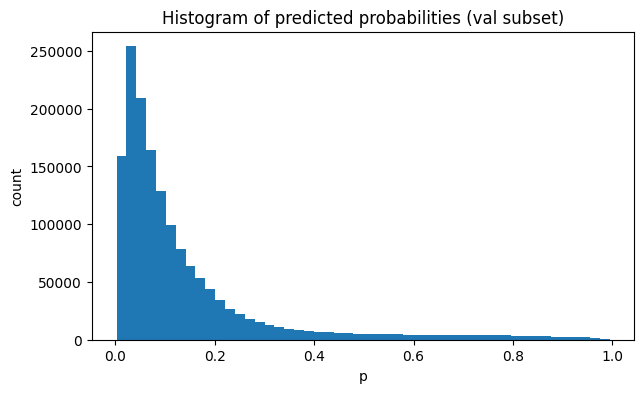

In [ ]:
import matplotlib.pyplot as plt

def batch_metrics(p, y, thr=0.5):
    pred = (p >= thr).float()
    tp = (pred * y).sum().item()
    fp = (pred * (1 - y)).sum().item()
    fn = ((1 - pred) * y).sum().item()
    tn = ((1 - pred) * (1 - y)).sum().item()

    eps = 1e-9
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    iou = tp / (tp + fp + fn + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    return {"acc": acc, "precision": precision, "recall": recall, "iou": iou}

@torch.no_grad()
def visualize_predictions(model, loader, n_samples=2, thr=0.5):
    model.eval()

    X, y = next(iter(loader))
    X = X.to(device)
    y = y.to(device)

    logits = model(X)
    p = torch.sigmoid(logits)

    p_flat = p.detach().cpu().flatten()
    y_flat = y.detach().cpu().flatten()
    m = batch_metrics(p_flat, y_flat, thr=thr)
    print(f"[Val batch metrics @thr={thr}] acc={m['acc']:.4f} precision={m['precision']:.4f} recall={m['recall']:.4f} iou={m['iou']:.4f}")

    n = min(n_samples, X.shape[0])
    for i in range(n):
        yi = y[i, 0].detach().cpu().numpy()
        pi = p[i, 0].detach().cpu().numpy()
        mi = (pi >= thr).astype(np.float32)

        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].set_title("y (GT)")
        ax[0].imshow(yi)
        ax[0].axis("off")

        ax[1].set_title("p = sigmoid(logits)")
        im = ax[1].imshow(pi)
        ax[1].axis("off")
        plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

        ax[2].set_title(f"mask (p>{thr})")
        ax[2].imshow(mi)
        ax[2].axis("off")

        plt.show()

@torch.no_grad()
def val_summary(model, loader, max_batches=30):
    model.eval()
    ps = []
    ys = []
    for b, (X, y) in enumerate(loader):
        if b >= max_batches:
            break
        X = X.to(device)
        y = y.to(device)
        p = torch.sigmoid(model(X))
        ps.append(p.detach().cpu().flatten())
        ys.append(y.detach().cpu().flatten())

    p_all = torch.cat(ps)
    y_all = torch.cat(ys)

    for thr in [0.3, 0.5, 0.7]:
        m = batch_metrics(p_all, y_all, thr=thr)
        print(f"[Val subset @thr={thr}] acc={m['acc']:.4f} precision={m['precision']:.4f} recall={m['recall']:.4f} iou={m['iou']:.4f}")

    plt.figure(figsize=(7,4))
    plt.title("Histogram of predicted probabilities (val subset)")
    plt.hist(p_all.numpy(), bins=50)
    plt.xlabel("p")
    plt.ylabel("count")
    plt.show()


ckpt = torch.load(save_path, map_location=device)
model.load_state_dict(ckpt["model_state"])
model.to(device)

print("Loaded best model from:", save_path)

visualize_predictions(model, val_loader, n_samples=2, thr=0.5)
val_summary(model, val_loader, max_batches=30)

## exp 2

1) новый Loss
2) добавил фичи (получены из старых)

    было 26, добавил: wind_speed(4) + dewpoint_depression(4) = +8

In [ ]:
exp = "exp_2"

### dataset

In [ ]:
class Era5WeeklyRiskDataset(Dataset):
    def __init__(
        self,
        tp_hourly_path: str,
        vars6h_paths: dict,
        start_date_utc: str,
        past_days: int = 7,
        horizon_days: int = 7,
        threshold_mm: float = 20.0,
        max_days: int | None = None,
        day_indices=None,
        norm_mean: torch.Tensor | None = None,
        norm_std: torch.Tensor | None = None,
    ):
        super().__init__()

        self.tp = np.load(tp_hourly_path, mmap_mode="r")
        require_3d("tp_hourly", self.tp)

        self.vars6h = {}
        for k, p in vars6h_paths.items():
            arr = np.load(p, mmap_mode="r")
            require_3d(k, arr)
            self.vars6h[k] = arr

        Th, H, W = self.tp.shape
        any6 = next(iter(self.vars6h.values()))
        T6, H2, W2 = any6.shape
        assert (H, W) == (H2, W2), "Spatial mismatch between tp and 6h variables"

        assert Th % 24 == 0, f"tp hours must be divisible by 24, got {Th}"
        assert T6 % 4 == 0, f"6h timesteps must be divisible by 4, got {T6}"

        D_tp = Th // 24
        D_6h = T6 // 4
        D_common = min(D_tp, D_6h)
        if max_days is not None:
            D_common = min(D_common, int(max_days))

        self.H, self.W = H, W
        self.D = D_common
        self.past_days = int(past_days)
        self.horizon_days = int(horizon_days)
        self.threshold_mm = float(threshold_mm)

        self.start_date = datetime.strptime(start_date_utc, "%Y-%m-%d")

        d_min = self.past_days - 1
        d_max = self.D - self.horizon_days - 1
        assert d_max >= d_min, f"Not enough days. D={self.D}, need past={self.past_days}, horizon={self.horizon_days}"

        if day_indices is None:
            self.day_indices = np.arange(d_min, d_max + 1, dtype=np.int32)
        else:
            di = np.asarray(day_indices, dtype=np.int32)
            ok = (di >= d_min) & (di <= d_max)
            self.day_indices = di[ok]

        self.var_order = ["msl", "u10", "v10", "t2m", "d2m"]
        for v in self.var_order:
            if v not in self.vars6h:
                raise KeyError(f"Missing 6h variable {v}")

        self.num_channels = 34

        self.norm_mean = norm_mean
        self.norm_std = norm_std

    def __len__(self):
        return len(self.day_indices)

    def _tp24_block_mm(self, day_start: int, day_end_exclusive: int) -> np.ndarray:
        assert 0 <= day_start < day_end_exclusive <= self.D
        h0 = day_start * 24
        h1 = day_end_exclusive * 24
        block = self.tp[h0:h1].astype(np.float32) * 1000.0
        num_days = day_end_exclusive - day_start
        return block.reshape(num_days, 24, self.H, self.W).sum(axis=1, dtype=np.float32)

    def _seasonal_maps(self, day: int):
        date = self.start_date + timedelta(days=int(day))
        doy = date.timetuple().tm_yday
        angle = 2.0 * math.pi * (doy / 365.0)
        s = math.sin(angle)
        c = math.cos(angle)
        sin_map = np.full((self.H, self.W), s, dtype=np.float32)
        cos_map = np.full((self.H, self.W), c, dtype=np.float32)
        return sin_map, cos_map

    def __getitem__(self, idx: int):
        d = int(np.asarray(self.day_indices[idx]).item())

        X_channels = []

        t6_start = (d - (self.past_days - 1)) * 4
        t6_end = (d + 1) * 4
        n_last2 = 2 * 4

        u10_week = v10_week = t2m_week = d2m_week = None

        for v in self.var_order:
            arr = self.vars6h[v][t6_start:t6_end].astype(np.float32)

            if v == "u10":
                u10_week = arr
            elif v == "v10":
                v10_week = arr
            elif v == "t2m":
                t2m_week = arr
            elif v == "d2m":
                d2m_week = arr

            mean_7d = arr.mean(axis=0, dtype=np.float32)
            min_7d = arr.min(axis=0)
            max_7d = arr.max(axis=0)

            last2 = arr[-n_last2:]
            prev5 = arr[:-n_last2]
            trend = last2.mean(axis=0, dtype=np.float32) - prev5.mean(axis=0, dtype=np.float32)

            X_channels.extend([mean_7d, min_7d, max_7d, trend])

        assert u10_week is not None and v10_week is not None and t2m_week is not None and d2m_week is not None

        ws = np.sqrt(u10_week * u10_week + v10_week * v10_week).astype(np.float32)
        ws_mean = ws.mean(axis=0, dtype=np.float32)
        ws_min = ws.min(axis=0)
        ws_max = ws.max(axis=0)
        ws_trend = ws[-n_last2:].mean(axis=0, dtype=np.float32) - ws[:-n_last2].mean(axis=0, dtype=np.float32)
        X_channels.extend([ws_mean, ws_min, ws_max, ws_trend])

        dd = (t2m_week - d2m_week).astype(np.float32)
        dd_mean = dd.mean(axis=0, dtype=np.float32)
        dd_min = dd.min(axis=0)
        dd_max = dd.max(axis=0)
        dd_trend = dd[-n_last2:].mean(axis=0, dtype=np.float32) - dd[:-n_last2].mean(axis=0, dtype=np.float32)
        X_channels.extend([dd_mean, dd_min, dd_max, dd_trend])

        tp24_past = self._tp24_block_mm(d - 6, d + 1)
        tp24_today = tp24_past[-1]
        tp24_yday = tp24_past[-2]
        tp24_sum_7d = tp24_past.sum(axis=0, dtype=np.float32)
        tp24_max_7d = tp24_past.max(axis=0)
        X_channels.extend([tp24_today, tp24_yday, tp24_sum_7d, tp24_max_7d])

        sin_map, cos_map = self._seasonal_maps(d)
        X_channels.extend([sin_map, cos_map])

        X = np.stack(X_channels, axis=0).astype(np.float32)

        tp24_future = self._tp24_block_mm(d + 1, d + 1 + self.horizon_days)
        future_max = tp24_future.max(axis=0)
        y = (future_max > self.threshold_mm).astype(np.float32)[None, :, :]

        X_t = torch.from_numpy(X)
        y_t = torch.from_numpy(y)

        if self.norm_mean is not None and self.norm_std is not None:
            X_t = (X_t - self.norm_mean[:, None, None]) / self.norm_std[:, None, None]

        X_t = sanitize_np(X_t)
        y_t = sanitize_np(y_t)
        return X_t, y_t


### model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3, bias=True):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        padding = kernel_size // 2
        self.conv = nn.Conv2d(
            input_dim + hidden_dim, 4 * hidden_dim,
            kernel_size=kernel_size, padding=padding, bias=bias
        )

    def forward(self, x, state):
        h, c = state
        combined = torch.cat([x, h], dim=1)
        gates = self.conv(combined)
        i, f, o, g = torch.chunk(gates, 4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_state(self, batch, spatial_size, device, dtype):
        H, W = spatial_size
        h = torch.zeros(batch, self.hidden_dim, H, W, device=device, dtype=dtype)
        c = torch.zeros(batch, self.hidden_dim, H, W, device=device, dtype=dtype)
        return h, c


class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dims=(64, 64), kernel_size=3, dropout=0.0):
        super().__init__()
        self.num_layers = len(hidden_dims)
        self.hidden_dims = hidden_dims
        self.dropout = float(dropout)

        cells = []
        for i in range(self.num_layers):
            in_dim = input_dim if i == 0 else hidden_dims[i-1]
            cells.append(ConvLSTMCell(in_dim, hidden_dims[i], kernel_size=kernel_size))
        self.cells = nn.ModuleList(cells)

    def forward(self, x):
        B, T, C, H, W = x.shape
        device = x.device
        dtype = x.dtype

        layer_input = x
        last_states = []

        for li, cell in enumerate(self.cells):
            h, c = cell.init_state(B, (H, W), device, dtype)
            outputs = []

            for t in range(T):
                h, c = cell(layer_input[:, t], (h, c))
                outputs.append(h)

            out = torch.stack(outputs, dim=1)

            if self.dropout > 0 and li < self.num_layers - 1:
                out = F.dropout(out, p=self.dropout, training=self.training)

            layer_input = out
            last_states.append((h, c))

        return last_states[-1][0]


class ConvLSTMSeg(nn.Module):
    def __init__(self, in_channels=26, hidden_dims=(64, 64), kernel_size=3, head_channels=64, dropout=0.1):
        super().__init__()
        self.convlstm = ConvLSTM(
            input_dim=in_channels,
            hidden_dims=hidden_dims,
            kernel_size=kernel_size,
            dropout=dropout
        )

        hidden_last = hidden_dims[-1]
        self.head = nn.Sequential(
            nn.Conv2d(hidden_last, head_channels, 3, padding=1),
            nn.GroupNorm(8, head_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(head_channels, head_channels, 3, padding=1),
            nn.GroupNorm(8, head_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(head_channels, 1, 1),
        )

    def forward(self, x):
        if x.ndim == 4:
            x = x.unsqueeze(1)
        h_last = self.convlstm(x)
        logits = self.head(h_last)
        return logits


### Loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AsymmetricFocalLoss(nn.Module):

    def __init__(self, gamma_pos=1.0, gamma_neg=4.0, clip=0.0, pos_weight=None, reduction="mean"):
        super().__init__()
        self.gamma_pos = float(gamma_pos)
        self.gamma_neg = float(gamma_neg)
        self.clip = float(clip)
        self.register_buffer("pos_weight", pos_weight if pos_weight is not None else None)
        self.reduction = reduction

    def forward(self, logits, targets):
        targets = targets.type_as(logits)

        bce = F.binary_cross_entropy_with_logits(
            logits, targets, reduction="none", pos_weight=self.pos_weight
        )

        p = torch.sigmoid(logits)

        if self.clip > 0:
            p = torch.clamp(p, self.clip, 1.0 - self.clip)

        w_pos = (1.0 - p) ** self.gamma_pos
        w_neg = (p) ** self.gamma_neg
        w = w_pos * targets + w_neg * (1.0 - targets)

        loss = w * bce

        if self.reduction == "mean":
            return loss.mean()
        if self.reduction == "sum":
            return loss.sum()
        return loss


### Запуск

In [ ]:
train_ds_raw = Era5WeeklyRiskDataset(
    tp_hourly_path=tp_path,
    vars6h_paths=vars6h_paths,
    start_date_utc=START_DATE_UTC,
    past_days=PAST_DAYS,
    horizon_days=HORIZON_DAYS,
    threshold_mm=THRESHOLD_MM,
    max_days=D_common,
    day_indices=train_days,
)

train_loader_raw = DataLoader(
    train_ds_raw, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

mean, std = compute_norm_stats(train_loader_raw, num_channels=train_ds_raw.num_channels)
pos_weight = compute_pos_weight(train_loader_raw)

print("mean/std shapes:", mean.shape, std.shape)
print("pos_weight:", pos_weight.item())

Compute pos_weight: 100%|██████████| 140/140 [00:10<00:00, 13.62it/s]

mean/std shapes: torch.Size([34]) torch.Size([34])
pos_weight: 33.38588333129883


In [ ]:
train_ds = Era5WeeklyRiskDataset(
    tp_hourly_path=tp_path,
    vars6h_paths=vars6h_paths,
    start_date_utc=START_DATE_UTC,
    past_days=PAST_DAYS,
    horizon_days=HORIZON_DAYS,
    threshold_mm=THRESHOLD_MM,
    max_days=D_common,
    day_indices=train_days,
    norm_mean=mean,
    norm_std=std,
)

val_ds = Era5WeeklyRiskDataset(
    tp_hourly_path=tp_path,
    vars6h_paths=vars6h_paths,
    start_date_utc=START_DATE_UTC,
    past_days=PAST_DAYS,
    horizon_days=HORIZON_DAYS,
    threshold_mm=THRESHOLD_MM,
    max_days=D_common,
    day_indices=val_days,
    norm_mean=mean,
    norm_std=std,
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

X0, y0 = next(iter(train_loader))
print("X batch:", X0.shape, "y batch:", y0.shape)

X batch: torch.Size([2, 34, 125, 205]) y batch: torch.Size([2, 1, 125, 205])


In [ ]:
model = ResUNet(in_channels=train_ds.num_channels, out_channels=1, base=BASE_CHANNELS).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

criterion = AsymmetricFocalLoss(
    gamma_pos=1.0,
    gamma_neg=4.0,
    clip=0.01,
    pos_weight=pos_weight.to(device)
)


best_val_brier = float("inf")
save_path = os.path.join(BASE_DIR, f"{exp}.pt")

for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss = validate(model, val_loader, criterion)

    va_brier = brier_score(model, val_loader)
    va_ece = ece_score(model, val_loader, n_bins=10, max_batches=20)

    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | "
          f"val_brier={va_brier:.5f} | val_ece≈{va_ece:.5f}")

    if va_brier < best_val_brier:
        best_val_brier = va_brier
        torch.save(
            {
                "model_state": model.state_dict(),
                "norm_mean": mean,
                "norm_std": std,
                "pos_weight": pos_weight,
                "config": {
                    "past_days": PAST_DAYS,
                    "horizon_days": HORIZON_DAYS,
                    "threshold_mm": THRESHOLD_MM,
                    "base_channels": BASE_CHANNELS,
                    "start_date_utc": START_DATE_UTC,
                    "days_used": D_common,
                }
            },
            save_path
        )
        print("Saved best model to:", save_path)

print("Done. Best val_brier:", best_val_brier)

Epoch 01 | train_loss=0.2863 | val_loss=0.1965 | val_brier=0.33490 | val_ece≈0.57907
Saved best model to: /content/drive/MyDrive/cmc/nauchka/data/exp_2.pt


Epoch 02 | train_loss=0.2571 | val_loss=0.1542 | val_brier=0.23870 | val_ece≈0.49444
Saved best model to: /content/drive/MyDrive/cmc/nauchka/data/exp_2.pt


Epoch 03 | train_loss=0.2325 | val_loss=0.1720 | val_brier=0.27164 | val_ece≈0.51651


Epoch 04 | train_loss=0.2167 | val_loss=0.1575 | val_brier=0.20497 | val_ece≈0.45420
Saved best model to: /content/drive/MyDrive/cmc/nauchka/data/exp_2.pt


Epoch 05 | train_loss=0.1924 | val_loss=0.1693 | val_brier=0.17949 | val_ece≈0.41695
Saved best model to: /content/drive/MyDrive/cmc/nauchka/data/exp_2.pt
Done. Best val_brier: 0.1794924537238676


## exp 3

1) все то же, что и в exp2
2) попробовал другую модель - временную

In [ ]:
exp = "exp_3"

In [ ]:
model = ConvLSTMSeg(in_channels=train_ds.num_channels, hidden_dims=(64,64)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

criterion = AsymmetricFocalLoss(
    gamma_pos=1.0,
    gamma_neg=4.0,
    clip=0.01,
    pos_weight=pos_weight.to(device)
)


best_val_brier = float("inf")
save_path = os.path.join(BASE_DIR, f"{exp}.pt")

for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss = validate(model, val_loader, criterion)

    va_brier = brier_score(model, val_loader)
    va_ece = ece_score(model, val_loader, n_bins=10, max_batches=20)

    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | "
          f"val_brier={va_brier:.5f} | val_ece≈{va_ece:.5f}")

    if va_brier < best_val_brier:
        best_val_brier = va_brier
        torch.save(
            {
                "model_state": model.state_dict(),
                "norm_mean": mean,
                "norm_std": std,
                "pos_weight": pos_weight,
                "config": {
                    "past_days": PAST_DAYS,
                    "horizon_days": HORIZON_DAYS,
                    "threshold_mm": THRESHOLD_MM,
                    "base_channels": BASE_CHANNELS,
                    "start_date_utc": START_DATE_UTC,
                    "days_used": D_common,
                }
            },
            save_path
        )
        print("Saved best model to:", save_path)

print("Done. Best val_brier:", best_val_brier)

Epoch 01 | train_loss=0.2615 | val_loss=0.1446 | val_brier=0.26912 | val_ece≈0.52680
Saved best model to: /content/drive/MyDrive/cmc/nauchka/data/exp_3.pt


Epoch 02 | train_loss=0.2455 | val_loss=0.1361 | val_brier=0.20628 | val_ece≈0.46199
Saved best model to: /content/drive/MyDrive/cmc/nauchka/data/exp_3.pt


Epoch 03 | train_loss=0.2342 | val_loss=0.1468 | val_brier=0.19916 | val_ece≈0.44863
Saved best model to: /content/drive/MyDrive/cmc/nauchka/data/exp_3.pt


Epoch 04 | train_loss=0.2270 | val_loss=0.1409 | val_brier=0.17220 | val_ece≈0.42586
Saved best model to: /content/drive/MyDrive/cmc/nauchka/data/exp_3.pt


Epoch 05 | train_loss=0.2195 | val_loss=0.1414 | val_brier=0.17938 | val_ece≈0.43243
Done. Best val_brier: 0.17220419016768293


Loaded best model from: /content/drive/MyDrive/cmc/nauchka/data/exp_3.pt
[Val batch metrics @thr=0.5] acc=0.5536 precision=0.0227 recall=0.8212 iou=0.0226


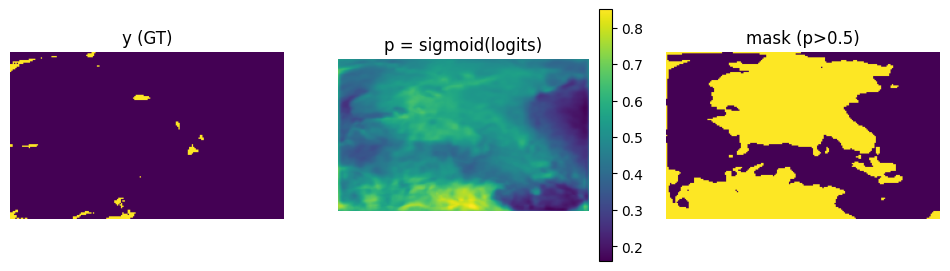

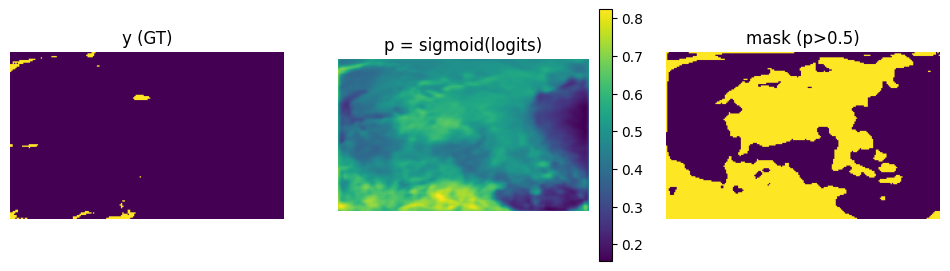

[Val subset @thr=0.3] acc=0.2351 precision=0.0172 recall=0.9913 iou=0.0172
[Val subset @thr=0.5] acc=0.7637 precision=0.0395 recall=0.7058 iou=0.0388
[Val subset @thr=0.7] acc=0.9694 precision=0.1688 recall=0.3217 iou=0.1245


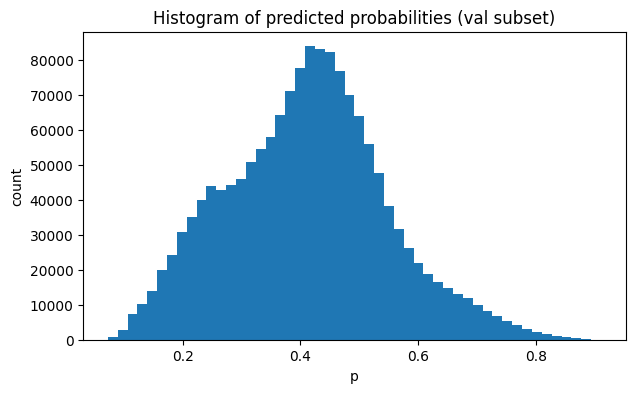

In [ ]:
import matplotlib.pyplot as plt

def batch_metrics(p, y, thr=0.5):
    pred = (p >= thr).float()
    tp = (pred * y).sum().item()
    fp = (pred * (1 - y)).sum().item()
    fn = ((1 - pred) * y).sum().item()
    tn = ((1 - pred) * (1 - y)).sum().item()

    eps = 1e-9
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    iou = tp / (tp + fp + fn + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    return {"acc": acc, "precision": precision, "recall": recall, "iou": iou}

@torch.no_grad()
def visualize_predictions(model, loader, n_samples=2, thr=0.5):
    model.eval()

    X, y = next(iter(loader))
    X = X.to(device)
    y = y.to(device)

    logits = model(X)
    p = torch.sigmoid(logits)

    p_flat = p.detach().cpu().flatten()
    y_flat = y.detach().cpu().flatten()
    m = batch_metrics(p_flat, y_flat, thr=thr)
    print(f"[Val batch metrics @thr={thr}] acc={m['acc']:.4f} precision={m['precision']:.4f} recall={m['recall']:.4f} iou={m['iou']:.4f}")

    n = min(n_samples, X.shape[0])
    for i in range(n):
        yi = y[i, 0].detach().cpu().numpy()
        pi = p[i, 0].detach().cpu().numpy()
        mi = (pi >= thr).astype(np.float32)

        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].set_title("y (GT)")
        ax[0].imshow(yi)
        ax[0].axis("off")

        ax[1].set_title("p = sigmoid(logits)")
        im = ax[1].imshow(pi)
        ax[1].axis("off")
        plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

        ax[2].set_title(f"mask (p>{thr})")
        ax[2].imshow(mi)
        ax[2].axis("off")

        plt.show()

@torch.no_grad()
def val_summary(model, loader, max_batches=30):
    model.eval()
    ps = []
    ys = []
    for b, (X, y) in enumerate(loader):
        if b >= max_batches:
            break
        X = X.to(device)
        y = y.to(device)
        p = torch.sigmoid(model(X))
        ps.append(p.detach().cpu().flatten())
        ys.append(y.detach().cpu().flatten())

    p_all = torch.cat(ps)
    y_all = torch.cat(ys)

    for thr in [0.3, 0.5, 0.7]:
        m = batch_metrics(p_all, y_all, thr=thr)
        print(f"[Val subset @thr={thr}] acc={m['acc']:.4f} precision={m['precision']:.4f} recall={m['recall']:.4f} iou={m['iou']:.4f}")

    plt.figure(figsize=(7,4))
    plt.title("Histogram of predicted probabilities (val subset)")
    plt.hist(p_all.numpy(), bins=50)
    plt.xlabel("p")
    plt.ylabel("count")
    plt.show()


ckpt = torch.load(save_path, map_location=device)
model.load_state_dict(ckpt["model_state"])
model.to(device)

print("Loaded best model from:", save_path)

visualize_predictions(model, val_loader, n_samples=2, thr=0.5)
val_summary(model, val_loader, max_batches=30)

## exp 4 (AR)

In [ ]:
# import numpy as np

# def hourly_to_6h(x, mode):
#     n = (x.shape[0] // 6) * 6
#     x = x[:n].reshape(-1, 6, *x.shape[1:])
#     if mode == "mean":
#         return x.mean(axis=1, dtype=np.float32)
#     if mode == "sum":
#         return x.sum(axis=1, dtype=np.float32)
#     if mode == "max":
#         return x.max(axis=1)
#     if mode == "last":
#         return x[:, -1]
#     raise ValueError(mode)

# # tcwv_h = np.load("tcwv_hourly.npy")
# # ivt_h = np.load("ivt_hourly.npy")
# tcwv_h = np.random.randn(8688, 125, 205)
# ivt_h = np.random.randn(8688, 125, 205)

# tcwv_6h = hourly_to_6h(tcwv_h.astype(np.float32), "mean")
# ivt_6h = hourly_to_6h(ivt_h.astype(np.float32), "mean")

# np.save("tcwv_6h.npy", tcwv_6h)
# np.save("ivt_6h.npy", ivt_6h)


In [ ]:
# import numpy as np
# import torch
# from torch.utils.data import Dataset, DataLoader

# class Era5SeqForecastMaskDataset(Dataset):
#     def __init__(self, x_paths, y_path, T, lead_steps, stride=1, indices=None, norm_mean=None, norm_std=None):
#         self.x = [np.load(p, mmap_mode="r") for p in x_paths]
#         self.y = np.load(y_path, mmap_mode="r")
#         self.T = int(T)
#         self.lead = int(lead_steps)
#         self.stride = int(stride)
#         n = min([a.shape[0] for a in self.x] + [self.y.shape[0]])
#         self.n = n
#         self.max_i = n - (self.T - 1) * self.stride - self.lead
#         if self.max_i <= 0:
#             raise ValueError("not enough timesteps")
#         if indices is None:
#             self.indices = np.arange(self.max_i, dtype=np.int64)
#         else:
#             idx = np.asarray(indices, dtype=np.int64)
#             self.indices = idx[(idx >= 0) & (idx < self.max_i)]
#         self.norm_mean = norm_mean
#         self.norm_std = norm_std

#     def __len__(self):
#         return int(self.indices.shape[0])

#     def __getitem__(self, k):
#         i = int(self.indices[k])
#         idxs = i + np.arange(self.T, dtype=np.int64) * self.stride
#         y_idx = int(idxs[-1] + self.lead)
#         x = np.stack([a[idxs].astype(np.float32) for a in self.x], axis=1)
#         y = self.y[y_idx].astype(np.float32)[None, :, :]
#         x_t = torch.from_numpy(x)
#         y_t = torch.from_numpy(y)
#         if self.norm_mean is not None and self.norm_std is not None:
#             x_t = (x_t - self.norm_mean[None, :, None, None]) / (self.norm_std[None, :, None, None] + 1e-6)
#         return x_t, y_t


In [ ]:
# import numpy as np
# import torch

# N = np.load("tcwv_6h.npy", mmap_mode="r").shape[0]
# T = 8
# L = 4
# max_i = N - (T - 1) - L

# split = int(0.9 * max_i)
# train_idx = np.arange(0, split, dtype=np.int64)
# val_idx = np.arange(split, max_i, dtype=np.int64)

# ds_ar = Era5SeqForecastMaskDataset(
#     x_paths=["tcwv_6h.npy", "ivt_6h.npy"],
#     y_path="ar_mask_6h.npy",
#     T=T,
#     lead_steps=L,
#     stride=1,
#     indices=train_idx
# )

# ds_ar_val = Era5SeqForecastMaskDataset(
#     x_paths=["tcwv_6h.npy", "ivt_6h.npy"],
#     y_path="ar_mask_6h.npy",
#     T=T,
#     lead_steps=L,
#     stride=1,
#     indices=val_idx
# )

# dl_ar = DataLoader(ds_ar, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
# dl_ar_val = DataLoader(ds_ar_val, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)


FileNotFoundError: [Errno 2] No such file or directory: 'ar_mask_6h.npy'

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class ConvLSTMCell(nn.Module):
#     def __init__(self, in_ch, hid_ch, k=3):
#         super().__init__()
#         p = k // 2
#         self.hid_ch = hid_ch
#         self.conv = nn.Conv2d(in_ch + hid_ch, 4 * hid_ch, k, padding=p)

#     def forward(self, x, state):
#         h, c = state
#         z = self.conv(torch.cat([x, h], dim=1))
#         i, f, o, g = torch.chunk(z, 4, dim=1)
#         i = torch.sigmoid(i)
#         f = torch.sigmoid(f)
#         o = torch.sigmoid(o)
#         g = torch.tanh(g)
#         c = f * c + i * g
#         h = o * torch.tanh(c)
#         return h, c

# class ConvLSTMSeg(nn.Module):
#     def __init__(self, in_ch, hid_ch=64, layers=2, out_ch=1, k=3):
#         super().__init__()
#         self.cells = nn.ModuleList([ConvLSTMCell(in_ch if i == 0 else hid_ch, hid_ch, k=k) for i in range(layers)])
#         self.head = nn.Conv2d(hid_ch, out_ch, kernel_size=1)

#     def forward(self, x):
#         B, T, C, H, W = x.shape
#         device = x.device
#         h = [torch.zeros(B, self.cells[i].hid_ch, H, W, device=device) for i in range(len(self.cells))]
#         c = [torch.zeros(B, self.cells[i].hid_ch, H, W, device=device) for i in range(len(self.cells))]
#         for t in range(T):
#             inp = x[:, t]
#             for i, cell in enumerate(self.cells):
#                 h[i], c[i] = cell(inp, (h[i], c[i]))
#                 inp = h[i]
#         return self.head(h[-1])

# def bce_dice_loss(logits, y, bce_w=0.5):
#     bce = F.binary_cross_entropy_with_logits(logits, y)
#     p = torch.sigmoid(logits)
#     num = 2.0 * (p * y).sum(dim=(2, 3)) + 1e-6
#     den = (p + y).sum(dim=(2, 3)) + 1e-6
#     dice = 1.0 - (num / den).mean()
#     return bce_w * bce + (1.0 - bce_w) * dice


In [ ]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt

# device = "cuda" if torch.cuda.is_available() else "cpu"

# def iou_score_from_logits(logits, y, thr=0.5):
#     p = torch.sigmoid(logits)
#     pb = (p > thr).float()
#     inter = (pb * y).sum(dim=(2,3))
#     union = (pb + y - pb*y).sum(dim=(2,3)) + 1e-6
#     return (inter / union).mean().item()

# def run_vis(model, dl_val, thr=0.5):
#     model.eval()
#     x, y = next(iter(dl_val))
#     x = x.to(device)
#     y = y.to(device)
#     with torch.no_grad():
#         logits = model(x)
#         p = torch.sigmoid(logits)
#     y0 = y[0,0].detach().cpu().numpy()
#     p0 = p[0,0].detach().cpu().numpy()
#     b0 = (p0 > thr).astype(np.float32)

#     plt.figure(figsize=(12,4))
#     plt.subplot(1,3,1); plt.imshow(y0); plt.title("y"); plt.axis("off")
#     plt.subplot(1,3,2); plt.imshow(p0); plt.title("p"); plt.axis("off")
#     plt.subplot(1,3,3); plt.imshow(b0); plt.title("p>thr"); plt.axis("off")
#     plt.tight_layout()
#     plt.show()


In [ ]:
# model_ar = ConvLSTMSeg(in_ch=2, hid_ch=64, layers=2, out_ch=1)

In [ ]:
# import torch

# model_ar = model_ar.to(device)
# opt_ar = torch.optim.Adam(model_ar.parameters(), lr=1e-3)

# epochs = 5
# for epoch in range(epochs):
#     model_ar.train()
#     tr_loss = 0.0
#     for x, y in dl_ar:
#         x = x.to(device)
#         y = y.to(device)
#         logits = model_ar(x)
#         loss = bce_dice_loss(logits, y, bce_w=0.5)
#         opt_ar.zero_grad()
#         loss.backward()
#         opt_ar.step()
#         tr_loss += loss.item()

#     model_ar.eval()
#     va_loss = 0.0
#     va_iou = 0.0
#     n = 0
#     with torch.no_grad():
#         for x, y in dl_ar_val:
#             x = x.to(device)
#             y = y.to(device)
#             logits = model_ar(x)
#             loss = bce_dice_loss(logits, y, bce_w=0.5)
#             va_loss += loss.item()
#             va_iou += iou_score_from_logits(logits, y, thr=0.5)
#             n += 1

#     print(epoch, tr_loss / max(1, len(dl_ar)), va_loss / max(1, n), va_iou / max(1, n))

# run_vis(model_ar, dl_ar_val, thr=0.5)


## Работа с чистыми данными за 2025 год

### dataset

In [2]:
# dataset.py
import numpy as np
import torch
from torch.utils.data import Dataset


class ERA5PrecipDataset(Dataset):
    """
    Baseline Dataset для прогноза осадков на 7 дней (дневные суммы) из ERA5.

    Вход:
      X.npy:        (T, C, H, W)
      Y_hourly.npy: (T, H, W)  осадки по часам в мм (или почти мм)

    Возвращает:
      X: (T_hist, C, ph, pw)  float32
      y: (7, ph, pw)          float32  (log1p(mm) если use_log_target=True)

    Особенности:
      - time windows: история T_hist, горизонт 168 часов (7*24)
      - random crop патчей (по умолчанию 64x64) чтобы влезало в память
      - очистка NaN/Inf в __getitem__:
          * X: "zero" или "channel_mean"
          * y: "zero" или "global_mean"
      - безопасная нормализация по train mean/std (std>=1e-3)
      - опциональный clip X после нормализации
    """

    def __init__(
        self,
        X_path: str,
        Y_hourly_path: str,
        indices: np.ndarray,
        T_hist: int = 48,
        patch_hw=(64, 64),
        train_stats=None,           # (mean[C], std[C]) — считать только по train
        use_log_target: bool = True,
        min_valid_hours: int = 168,
        # --- добавлено: очистка NaN/Inf ---
        x_fill: str = "zero",       # "zero" | "channel_mean"
        y_fill: str = "zero",       # "zero" | "global_mean"

        # --- добавлено: стабилизация ---
        clip_x: float | None = None # например 20.0 (после нормализации), или None
    ):
        self.min_valid_hours = int(min_valid_hours)
        self.X = np.load(X_path, mmap_mode="r")         # (T, C, H, W)
        self.Yh = np.load(Y_hourly_path, mmap_mode="r") # (T, H, W)
        self.indices = indices.astype(np.int64)

        self.T_hist = int(T_hist)
        self.patch_h, self.patch_w = int(patch_hw[0]), int(patch_hw[1])
        self.use_log_target = bool(use_log_target)

        self.T, self.C, self.H, self.W = self.X.shape

        self.mean = None
        self.std = None
        if train_stats is not None:
            mean, std = train_stats
            self.mean = np.asarray(mean, dtype=np.float32)
            self.std = np.asarray(std, dtype=np.float32)

        self.x_fill = x_fill
        self.y_fill = y_fill
        self.clip_x = clip_x

        # небольшой sanity-check по режимам
        if self.x_fill not in ("zero", "channel_mean"):
            raise ValueError(f"x_fill must be 'zero' or 'channel_mean', got {self.x_fill}")
        if self.y_fill not in ("zero", "global_mean"):
            raise ValueError(f"y_fill must be 'zero' or 'global_mean', got {self.y_fill}")

    def __len__(self):
        return len(self.indices)

    def _crop_xy(self, Xw: np.ndarray, y: np.ndarray, m: np.ndarray):
        if self.patch_h >= self.H or self.patch_w >= self.W:
            return Xw, y, m

        top = np.random.randint(0, self.H - self.patch_h + 1)
        left = np.random.randint(0, self.W - self.patch_w + 1)

        Xc = Xw[..., top:top+self.patch_h, left:left+self.patch_w]
        yc = y [..., top:top+self.patch_h, left:left+self.patch_w]
        mc = m [..., top:top+self.patch_h, left:left+self.patch_w]
        return Xc, yc, mc


    def _clean_X(self, Xw: np.ndarray) -> np.ndarray:
        """
        Xw: (T_hist, C, H, W)
        """
        if self.x_fill == "zero":
            return np.nan_to_num(Xw, nan=0.0, posinf=0.0, neginf=0.0)

        # channel_mean: заменяем NaN/Inf в каждом канале на среднее этого канала по окну
        Xw = Xw.copy()
        for c in range(Xw.shape[1]):
            ch = Xw[:, c]  # (T_hist, H, W)
            valid = np.isfinite(ch)
            if valid.any():
                m = ch[valid].mean(dtype=np.float64)
                ch[~valid] = m
            else:
                ch[:] = 0.0
            Xw[:, c] = ch

        return np.nan_to_num(Xw, nan=0.0, posinf=0.0, neginf=0.0)

    def _clean_y(self, y7: np.ndarray) -> np.ndarray:
        """
        y7: (7, H, W)
        """
        if self.y_fill == "zero":
            return np.nan_to_num(y7, nan=0.0, posinf=0.0, neginf=0.0)

        # global_mean
        valid = np.isfinite(y7)
        if valid.any():
            m = y7[valid].mean(dtype=np.float64)
            out = y7.copy()
            out[~valid] = m
            return np.nan_to_num(out, nan=0.0, posinf=0.0, neginf=0.0)

        return np.zeros_like(y7, dtype=np.float32)

    def __getitem__(self, i):
        t = int(self.indices[i])

        # --------- 1) окна истории ---------
        # Xw: (T_hist, C, H, W)
        Xw = np.array(self.X[t - self.T_hist + 1 : t + 1], dtype=np.float32)

        # --------- 2) таргет на 7 дней (дневные суммы) ---------
        start = t + 1
        end = t + 1 + 168
        Yfuture = np.array(self.Yh[start:end], dtype=np.float32)  # (168,H,W)

        valid = np.isfinite(Yfuture)                              # (168,H,W)
        valid_cnt = valid.sum(axis=0).astype(np.int16)            # (H,W)

        Yfuture = np.where(valid, Yfuture, np.nan).astype(np.float32)
        y_week = np.nansum(Yfuture, axis=0).astype(np.float32)    # (H,W)

        mask_week = (valid_cnt >= self.min_valid_hours).astype(np.float32)

        # --------- 3) очистка NaN/Inf ДО log/нормализации ---------
        Xw = self._clean_X(Xw)
        # y7 = self._clean_y(y7)

        # --------- 4) log1p по таргету (стабильнее из-за skew) ---------
        if self.use_log_target:
            y_week = np.log1p(np.clip(y_week, 0.0, None)).astype(np.float32)

        # --------- 5) нормализация X (только по train stats) ---------
        if self.mean is not None and self.std is not None:
            std = np.maximum(self.std.astype(np.float32), 1e-3)  # защита от std=0
            Xw = (Xw - self.mean[None, :, None, None]) / (std[None, :, None, None] + 1e-6)

        # --------- 6) финальная страховка ---------
        Xw = np.nan_to_num(Xw, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
        y_week = np.nan_to_num(y_week, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

        # --------- 7) optional clip после нормализации ---------
        if self.clip_x is not None:
            Xw = np.clip(Xw, -self.clip_x, self.clip_x).astype(np.float32)

        # --------- 8) random crop ---------
        Xw, y_week, mask_week = self._crop_xy(Xw, y_week, mask_week)
        return torch.from_numpy(Xw), torch.from_numpy(y_week), torch.from_numpy(mask_week)



def compute_train_stats(
    X_path: str,
    indices: np.ndarray,
    T_hist: int,
    max_samples: int = 512,
    min_std: float = 1e-3,
):
    """
    Быстрая оценка mean/std по train на подвыборке окон.
    Считает mean/std по каналам C.

    Возвращает:
      mean: (C,)
      std:  (C,)  с нижним порогом min_std
    """
    X = np.load(X_path, mmap_mode="r")
    T, C, H, W = X.shape

    rng = np.random.default_rng(42)
    pick = rng.choice(indices, size=min(len(indices), max_samples), replace=False)

    acc_mean = np.zeros((C,), dtype=np.float64)
    acc_sq = np.zeros((C,), dtype=np.float64)
    n = 0

    for t in pick:
        t = int(t)
        Xw = np.array(X[t - T_hist + 1 : t + 1], dtype=np.float32)  # (T_hist,C,H,W)
        # очистка на случай NaN в исходных данных при подсчёте статистик
        Xw = np.nan_to_num(Xw, nan=0.0, posinf=0.0, neginf=0.0)

        x = Xw.reshape(-1, C)  # (T_hist*H*W, C)
        acc_mean += x.mean(axis=0)
        acc_sq += (x ** 2).mean(axis=0)
        n += 1

    mean = (acc_mean / max(n, 1)).astype(np.float32)
    var = (acc_sq / max(n, 1) - mean.astype(np.float64) ** 2).astype(np.float32)
    std = np.sqrt(np.clip(var, 1e-6, None)).astype(np.float32)
    std = np.maximum(std, float(min_std)).astype(np.float32)
    return mean, std


### model


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvLSTMCell(nn.Module):
    def __init__(self, in_ch, hid_ch, k=3):
        super().__init__()
        pad = k // 2
        self.hid_ch = hid_ch
        self.conv = nn.Conv2d(in_ch + hid_ch, 4 * hid_ch, kernel_size=k, padding=pad)

    def forward(self, x, state):
        h, c = state
        inp = torch.cat([x, h], dim=1)
        gates = self.conv(inp)
        i, f, o, g = torch.chunk(gates, 4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)
        c = f * c + i * g
        h = o * torch.tanh(c)
        return h, c

    def init_state(self, batch, H, W, device):
        h = torch.zeros(batch, self.hid_ch, H, W, device=device)
        c = torch.zeros(batch, self.hid_ch, H, W, device=device)
        return h, c


class ConvLSTMQuantile(nn.Module):
    """
    Вход:  (B, T, C, H, W)
    Выход: (B, 2, H, W) -> q025 и q975 для недельной суммы в log-space
    """
    def __init__(self, in_ch, hid_ch=64, n_layers=2):
        super().__init__()
        self.embed = nn.Conv2d(in_ch, hid_ch, kernel_size=3, padding=1)
        self.cells = nn.ModuleList([ConvLSTMCell(hid_ch, hid_ch, k=3) for _ in range(n_layers)])
        self.head = nn.Conv2d(hid_ch, 2, kernel_size=1)

    def forward(self, x):
        B, T, C, H, W = x.shape
        device = x.device
        states = [cell.init_state(B, H, W, device) for cell in self.cells]

        for t in range(T):
            xt = F.relu(self.embed(x[:, t]))
            for li, cell in enumerate(self.cells):
                h, c = states[li]
                h, c = cell(xt, (h, c))
                states[li] = (h, c)
                xt = h

        h_last = states[-1][0]
        return self.head(h_last)  # (B,2,H,W)


def pinball_loss_masked(pred, target, q, mask, eps=1e-6):
    e = target - pred
    loss = torch.maximum(q * e, (q - 1) * e)
    loss = loss * mask
    return loss.sum() / (mask.sum() + eps)


def quantile_interval_loss_week_masked(pred_2, y, mask, q_low=0.025, q_high=0.975, monotone_weight=1.0):
    # pred_2: (B,2,H,W)  y: (B,H,W)  mask: (B,H,W)
    ql = pred_2[:, 0]
    qh = pred_2[:, 1]

    loss_low  = pinball_loss_masked(ql, y, q_low,  mask)
    loss_high = pinball_loss_masked(qh, y, q_high, mask)

    mono = (F.relu(ql - qh) * mask).sum() / (mask.sum() + 1e-6)
    return loss_low + loss_high + monotone_weight * mono



### trainloop

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# from dataset import ERA5PrecipDataset, compute_train_stats
# from model import ConvLSTMQuantile, quantile_interval_loss

def make_time_indices(T, T_hist, horizon=168):
    """
    t должен позволять взять историю и будущее:
      t - T_hist + 1 >= 0
      t + horizon < T
    """
    start = T_hist - 1
    end = T - horizon - 1
    return np.arange(start, end + 1, dtype=np.int64)

def split_by_month_like(T, train_frac=0.8, val_frac=0.1):
    """
    Простой time-split без календаря: train/val/test по времени.
    Лучше, чем random split.
    """
    idx = np.arange(T, dtype=np.int64)
    n = len(idx)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)
    train = idx[:n_train]
    val = idx[n_train:n_train+n_val]
    test = idx[n_train+n_val:]
    return train, val, test

@torch.no_grad()
def eval_epoch(model, loader, device,
               q_low=0.025, q_high=0.975, monotone_weight=1.0):
    """
    model: возвращает pred (B,2,H,W) в log-space
    loader: отдаёт (X, y, m)
        X: (B,T,C,H,W)
        y: (B,H,W)      в log-space (если ты делаешь log1p в Dataset)
        m: (B,H,W)      0/1 маска валидности
    Возвращает:
        avg_loss, coverage, mean_width_mm
    """
    model.eval()

    total_loss = 0.0
    n_samples = 0

    # агрегируем метрики "по пикселям" с учётом маски
    inside_sum = 0.0   # сколько валидных пикселей попало в интервал
    width_sum  = 0.0   # суммарная ширина интервала (в мм) по валидным пикселям
    mask_sum   = 0.0   # сколько валидных пикселей всего

    for X, y, m in loader:
        X = X.to(device, non_blocking=True)  # (B,T,C,H,W)
        y = y.to(device, non_blocking=True)  # (B,H,W) log-space
        m = m.to(device, non_blocking=True)  # (B,H,W) 0/1

        pred = model(X)  # (B,2,H,W)

        # ---- loss (masked) ----
        loss = quantile_interval_loss_week_masked(
            pred, y, m, q_low=q_low, q_high=q_high, monotone_weight=monotone_weight
        )

        bs = X.size(0)
        total_loss += float(loss.item()) * bs
        n_samples += bs

        # ---- метрики coverage/width в мм ----
        ql = pred[:, 0]  # (B,H,W) log-space
        qh = pred[:, 1]  # (B,H,W) log-space

        # log-space -> mm
        y_mm  = torch.expm1(y).clamp_min(0.0)
        ql_mm = torch.expm1(ql).clamp_min(0.0)
        qh_mm = torch.expm1(qh).clamp_min(0.0)

        inside = ((y_mm >= ql_mm) & (y_mm <= qh_mm)).float()  # (B,H,W)

        # маскируем: учитываем только валидные пиксели
        inside = inside * m
        width  = (qh_mm - ql_mm) * m

        inside_sum += inside.sum().item()
        width_sum  += width.sum().item()
        mask_sum   += m.sum().item()

    avg_loss = total_loss / max(n_samples, 1)
    coverage = inside_sum / (mask_sum + 1e-6)
    mean_width_mm = width_sum / (mask_sum + 1e-6)

    return avg_loss, coverage, mean_width_mm

def main(
    # prepared_dir="/content/drive/MyDrive/cmc/nauchka/data/clear_data/prepared",
    prepared_dir="drive/MyDrive/cmc/nauchka/data/prepared",
    out_dir="/content/drive/MyDrive/cmc/nauchka/baseline_ConvLSTM",
    T_hist=48,
    patch_hw=(64,64),
    batch_size=4,
    epochs=20,
    lr=1e-3,
    num_workers=2,
):
    os.makedirs(out_dir, exist_ok=True)

    X_path = os.path.join(prepared_dir, "X.npy")
    Y_path = os.path.join(prepared_dir, "Y_hourly.npy")

    X = np.load(X_path, mmap_mode="r")
    T, C, H, W = X.shape

    valid_t = make_time_indices(T, T_hist, horizon=168)
    train_t, val_t, test_t = split_by_month_like(len(valid_t), 0.8, 0.1)
    train_idx = valid_t[train_t]
    val_idx = valid_t[val_t]
    test_idx = valid_t[test_t]

    best_path = os.path.join(out_dir, "best.pt")

    # -----------------------------
    # 1) mean/std: resume-safe
    # -----------------------------
    mean = None
    std = None

    if os.path.isfile(best_path):
        # берем mean/std из чекпоинта, чтобы нормализация была консистентной
        ckpt_stats = torch.load(best_path, map_location="cpu", weights_only=False)
        if "mean" in ckpt_stats and "std" in ckpt_stats:
            mean = np.asarray(ckpt_stats["mean"], dtype=np.float32)
            std  = np.asarray(ckpt_stats["std"], dtype=np.float32)
            print(f"[resume] loaded mean/std from {best_path}")
        else:
            print(f"[resume] best.pt found but mean/std missing -> will recompute")

    if mean is None or std is None:
        mean, std = compute_train_stats(X_path, train_idx, T_hist, max_samples=256)
        np.save(os.path.join(out_dir, "mean.npy"), mean)
        np.save(os.path.join(out_dir, "std.npy"), std)
        print("[stats] computed and saved mean/std")

    # -----------------------------
    # 2) datasets / loaders
    # -----------------------------
    train_ds = ERA5PrecipDataset(
        X_path, Y_path, train_idx,
        T_hist=T_hist, patch_hw=patch_hw,
        train_stats=(mean, std),
        x_fill="channel_mean",
        y_fill="zero",
        clip_x=20.0
    )

    val_ds = ERA5PrecipDataset(
        X_path, Y_path, val_idx,
        T_hist=T_hist, patch_hw=patch_hw,
        train_stats=(mean, std),
        x_fill="channel_mean",
        y_fill="zero",
        clip_x=20.0
    )

    test_ds = ERA5PrecipDataset(
        X_path, Y_path, test_idx,
        T_hist=T_hist, patch_hw=patch_hw,
        train_stats=(mean, std),
        x_fill="channel_mean",
        y_fill="zero",
        clip_x=20.0
    )
    num_workers = 0 #<-------------------
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True)

    # -----------------------------
    # 3) model / optimizer / resume
    # -----------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ConvLSTMQuantile(in_ch=C, hid_ch=64, n_layers=2).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best_val = 1e9
    start_epoch = 1

    if os.path.isfile(best_path):
        ckpt = torch.load(best_path, map_location=device, weights_only=False)

        if "model" in ckpt:
            model.load_state_dict(ckpt["model"])
            print(f"[resume] loaded model from {best_path}")

        if "opt" in ckpt:
            try:
                opt.load_state_dict(ckpt["opt"])
                print("[resume] loaded optimizer state")
            except Exception as e:
                print(f"[resume] could not load optimizer state: {e}")

        best_val = float(ckpt.get("best_val", best_val))
        last_epoch = int(ckpt.get("epoch", 0))
        start_epoch = last_epoch + 1
        print(f"[resume] best_val={best_val:.6f}, start_epoch={start_epoch}")

    # если уже дообучили до epochs — просто пересчитаем test
    if start_epoch > epochs:
        print(f"[resume] start_epoch ({start_epoch}) > epochs ({epochs}) -> skip training")
    else:
        for ep in range(start_epoch, epochs + 1):
            model.train()
            pbar = tqdm(train_loader, desc=f"Epoch {ep}/{epochs}")
            run_loss = 0.0
            n = 0

            for Xb, yb, mb in pbar:
                Xb = Xb.to(device)      # (B,T,C,H,W)
                yb = yb.to(device)      # (B,H,W)
                mb = mb.to(device)

                pred = model(Xb)        # (B,2,H,W)
                loss = quantile_interval_loss_week_masked(pred, yb, mb, monotone_weight=1.0)

                opt.zero_grad(set_to_none=True)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                opt.step()

                run_loss += float(loss.item()) * Xb.size(0)
                n += Xb.size(0)
                pbar.set_postfix(loss=run_loss / max(n, 1))

            val_loss, val_cov, val_width = eval_epoch(model, val_loader, device)
            print(f"[val] loss={val_loss:.5f} coverage={val_cov:.3f} width(mm)={val_width:.3f}")

            if val_loss < best_val:
                best_val = val_loss
                torch.save(
                    {
                        "epoch": ep,
                        "best_val": best_val,
                        "model": model.state_dict(),
                        "opt": opt.state_dict(),
                        "mean": mean.astype(np.float32).tolist(),
                        "std":  std.astype(np.float32).tolist(),
                        "C": C,
                    },
                    best_path,
                )
                print("  saved best:", best_path)

    # -----------------------------
    # 4) final test on best
    # -----------------------------
    if os.path.isfile(best_path):
        ckpt = torch.load(best_path, map_location=device, weights_only=False)
        model.load_state_dict(ckpt["model"])
        test_loss, test_cov, test_width = eval_epoch(model, test_loader, device)
        print(f"[test] loss={test_loss:.5f} coverage={test_cov:.3f} width(mm)={test_width:.3f}")
    else:
        print("[test] best checkpoint not found, cannot evaluate best model")


if __name__ == "__main__":
    main()


[resume] loaded mean/std from /content/drive/MyDrive/cmc/nauchka/baseline_ConvLSTM/best.pt
[resume] loaded model from /content/drive/MyDrive/cmc/nauchka/baseline_ConvLSTM/best.pt
[resume] loaded optimizer state
[resume] best_val=0.095643, start_epoch=3


Epoch 3/20: 100%|██████████| 1709/1709 [2:17:06<00:00,  4.81s/it, loss=0.1]
